<a href="https://colab.research.google.com/github/valenja9/co_python_umi/blob/main/best_in_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Epidemická křivka a reprodukční číslo COVID-19 v České republice
* Na základě otevřených dat z ministerstva zdravotnictví.

In [ ]:
from urllib.request import urlopen
import json
from datetime import datetime
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from math import log2
from IPython.display import Markdown, display

In [ ]:
url = 'https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/nakazeni-vyleceni-umrti-testy.json'

with urlopen(url) as response: # download the data
    data = json.load(response)

In [ ]:
def cases(day):
    ''' Number of active cases for a given day '''
    return day['kumulativni_pocet_nakazenych'] \
         - day['kumulativni_pocet_vylecenych'] \
         - day['kumulativni_pocet_umrti']

# active cases for every day
daily_cases = [ cases(day) for day in data['data'] ] 
# dates in datetime format
dates = [ datetime.strptime(day['datum'], "%Y-%m-%d") for day in data['data'] ]

def moving_average(it, n):
    ''' Generate a moving average for a sequence of numbers '''
    q = deque([0] * n)
    for k in it:
        q.popleft()
        q.append(k)
        yield sum(q) / n

# 7-day averaged number of cases on a logarithmic scale
averaged_cases = [ log2(max(k,1)) for k in moving_average(daily_cases, 7) ]

tau = 5.61 # days
''' Daily number of cases is locally approximated as R^{T/tau}, where tau is
a single constant chosen to match other models of reproduction number R. '''
ac = averaged_cases
base = 2**tau
reproduction = [0] + [base**(ac[i]-ac[i-1]) for i in range(1, len(ac))]

# the first day to display on graphs
start_date = 60

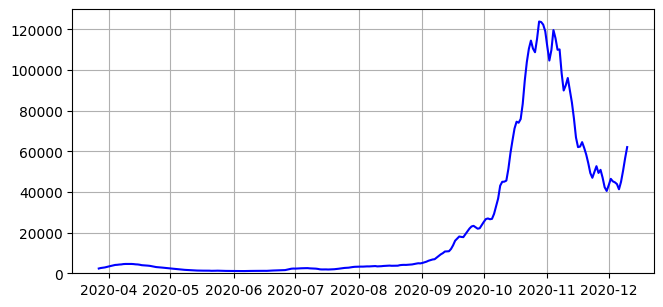

In [ ]:
# daily cases
plt.figure(figsize = (7.5, 3.5), dpi = 100)
plt.plot_date(date2num(dates[start_date:]), daily_cases[start_date:], fmt='b-')
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

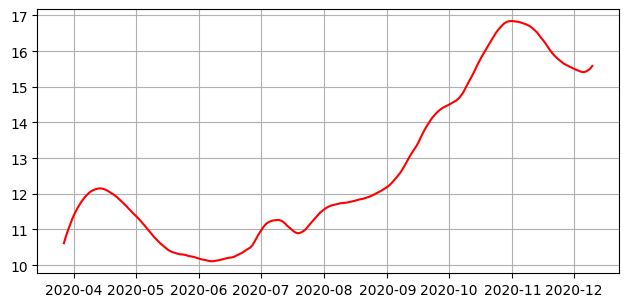

In [ ]:
# averaged daily cases
plt.figure(figsize = (7.5, 3.5), dpi = 100)
plt.plot_date(date2num(dates[start_date:]), averaged_cases[start_date:], fmt='r-')
plt.grid(True)
plt.show()

* Červený graf je vyhlazená epidemická křivka v logaritmickém měřítku.
* Ukazuje **klouzavý průměr** za 7 předchozích dní, čímž eliminuje skoky způsobené malým počtem testů o víkendu apod.
* Jeden dílek na svislé ose znamená **dvojnásobek**.
* Přímka v tomto grafu znamená exponenciální nárůst resp. pokles.
* Dobře je vidět jarní vlna epidemie, v červenci malý ale zřetelný peak - patrně horníci na Ostravsku.
* Od začátku srpna postupně nabíhá podzimní vlna. Její nástup se zásadně urychlil v době návratu z dovolených a otevření škol.
* Maximum je o 5 dílků vyšší než na jaře, tj. zhruba 30&times;.
* Pokles od maxima křivky je zatím o 1 dílek, tj. na polovinu.

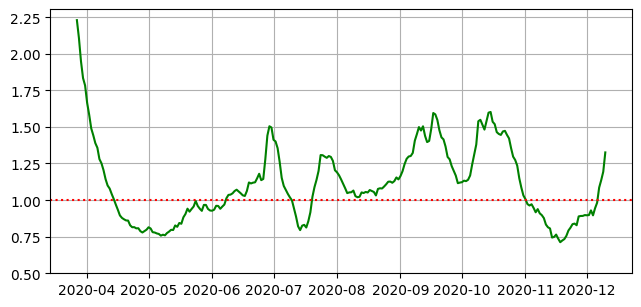

$$R(\mathrm{today}) \approx 1.33$$

In [ ]:
# estimated reproduction number
plt.figure(figsize = (7.5, 3.5), dpi = 100)
plt.plot_date(date2num(dates[start_date:]), reproduction[start_date:], fmt='g-')
plt.axhline(y=1.0, color='r', linestyle=':')
plt.ylim(bottom=0.5)
plt.grid(True)
plt.show()
string = '$$R(\mathrm{today}) \\approx ' + f'{reproduction[-1]:.2f}$$'
display(Markdown(string))

* Zelená křivka je odhad reprodukčního čísla $R$, jak se vyvíjí v čase.
* Je-li $R$ blízké jedničce nebo nižší, je vývoj epidemie pod kontrolou.
* Při $R > 1{,}1$ počet nakažených prudce roste.
* Jde o zjednodušený model založený pouze na epidemické křivce. Dobře se shoduje s jinými modely, které jsou ale vyhodnocovány s větším zpožděním. ([Netík](https://netique.shinyapps.io/R_number_daily/), [Seznam](https://www.seznamzpravy.cz/sekce/koronavirus-stopcovid))
